> Solve Kuramoto–Sivashinsky with PIML

<center>$\large \frac{\partial u}{\partial t}=-v\frac{\partial^4 u}{\partial x^4}-\frac{\partial^2 u}{\partial x^2}-u\frac{\partial u}{\partial x}$</center>

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import progressbar
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
data = pd.read_parquet('Data/KS_data.parquet')

Scaling the data or PCA won't work

In [3]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data = data.applymap(lambda n: (n + 1) / 2) # set all values bewteen 0 and 1

In [4]:
data.loc[:10, :10]  # just an example

,0,1,2,3,4,5,6,7,8,9,10
0,-0.478193,-0.423484,-0.361481,-0.294564,-0.224610,-0.153012,-0.080711,-0.008241,0.064236,0.136886,0.210136
1,-0.422947,-0.359123,-0.291522,-0.221948,-0.151654,-0.081407,-0.011565,0.057864,0.127159,0.196825,0.267534
2,-0.355469,-0.286757,-0.217152,-0.147817,-0.079377,-0.012018,0.054417,0.120348,0.186393,0.253301,0.321885
3,-0.280954,-0.210939,-0.142184,-0.075218,-0.010091,0.053510,0.116160,0.178607,0.241705,0.306349,0.373406
4,-0.204034,-0.135486,-0.069613,-0.006376,0.054664,0.114221,0.173183,0.232528,0.293251,0.356305,0.422529
5,-0.128438,-0.063269,-0.001522,0.057319,0.114079,0.169773,0.225505,0.282389,0.341478,0.403704,0.469814
6,-0.056850,0.003817,0.060877,0.115222,0.167962,0.220317,0.273522,0.328744,0.387020,0.449199,0.515869
7,0.009049,0.064755,0.117113,0.167289,0.216590,0.266360,0.317883,0.372313,0.430609,0.493473,0.561285
8,0.068433,0.119234,0.167275,0.213910,0.260565,0.308631,0.359380,0.413892,0.472988,0.537174,0.606572
9,0.121133,0.167462,0.211848,0.255763,0.300679,0.347975,0.398855,0.454267,0.514849,0.580858,0.652112


In [5]:
go.Figure(data =
    go.Contour(
        z=data.loc[:1000].to_numpy()
    )).write_image('images/problem_3_data_example.png')

![](images/problem_3_data_example.png)

In [6]:
def test_n_components_acc(n, data):
    pca = PCA(n_components=n)
    reduced_data = pca.fit_transform(data)
    aux = pca.inverse_transform(reduced_data)
    return mean_absolute_error(data, aux)

In [ ]:
pca_n_acc = []
for i in progressbar.progressbar(range(2, 50)):
    pca_n_acc.append(test_n_components_acc(i, data))

# I started with n_components up to 50 above, but results were bad even for 50, I just extended the test
# in order to save time, that's why the X of the chart looks like that

for i in progressbar.progressbar(range(50, 200, 10)):
    pca_n_acc.append(test_n_components_acc(i, data))

 41% (20 of 48) |##########              | Elapsed Time: 0:01:38 ETA:   0:02:27

In [ ]:
px.line(x=[*range(2, 50), *range(50, 200, 10)], y=pca_n_acc,
        title='Reduced data difference to real').write_image('images/PCA_components_test.png')

![](images/PCA_components_test.png)

I'll use 90 as the number of components, that's the first one where the difference to original on return is negligible

In [5]:
pca = PCA(n_components=90)

In [6]:
%%time
reduced_data = pca.fit_transform(data)

CPU times: total: 56.6 s
Wall time: 6.74 s


In [7]:
mean_absolute_error(data, pca.inverse_transform(reduced_data))

0.0006817917648193599

In [8]:
reduced_data = pd.DataFrame(reduced_data)

scale the reduced data

In [9]:
red_scaler = StandardScaler()
reduced_data = pd.DataFrame(red_scaler.fit_transform(reduced_data))
reduced_data = reduced_data.applymap(lambda n: (n + 1) / 2) # set all values bewteen 0 and 1

---

### LSTM

I want to try a LSTM, gonna start with a relatively tame one

reshape data

In [11]:
sample_size = 1000
X, y = [], []
for i in range(len(reduced_data) - (sample_size + 1)):
    X.append(reduced_data.loc[i:i + sample_size - 1].to_numpy())
    y.append(reduced_data.loc[i + sample_size].to_numpy())

In [12]:
len(X), len(y)

(198999, 198999)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [16]:
model = keras.Sequential()
model.add(layers.LSTM(128, input_shape=(1000, 90)))
model.add(layers.Dense(90))
model.compile()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               112128    
                                                                 
 dense_1 (Dense)             (None, 90)                11610     
                                                                 
Total params: 123,738
Trainable params: 123,738
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=1
)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

So the model is eating my whole vram even with batch_size = 1, there's no way I'm running this. Will change my approach to DeepONets

---

### DeepONets

In [19]:
import deepxde as dde

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




In [27]:
data = dde.data.TripleCartesianProd(X_train, np.array(y_train), X_test, y_test)

ValueError: The training dataset does not have the format of Cartesian product.

I have no idea what shape is the input expected to be in, [the docs are vague](https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.triple.TripleCartesianProd) and [the examples are no better](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html#complete-code)

---

### OpInf

[Willcox-Research-Group OpInf looks good and has docs, gonna try it](https://willcox-research-group.github.io/rom-operator-inference-Python3/content/index.html)

In [77]:
import opinf
import scipy.linalg as la
import matplotlib.pyplot as plt

In [65]:
Q = data.T

In [30]:
basis = opinf.pre.PODBasis().fit(q.to_numpy(), r=90)                # Construct the low-dimensional basis.

In [31]:
basis

PODBasis
Full-order dimension    n = 512
Reduced-order dimension r = 90

In [18]:
dt = 0.25

In [67]:
Qdot = opinf.pre.ddt(Q, dt)                    # Calculate the time derivative matrix.

In [68]:
Qdot.shape

(512, 200000)

In [23]:
rom = opinf.ContinuousOpInfROM(modelform='A')           # Define the model structure.

In [32]:
rom.fit(basis, Q, Qdot, regularizer=1e-2)               # Construct the ROM with OpInf.

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 512
Reduced-order dimension r = 90

In [42]:
q0 = q[0].to_numpy()

In [56]:
q0.shape

(512,)

In [54]:
t = []
start = 0
for i in range(len(q.columns)):
    t.append(start)
    start += dt

In [60]:
t = np.array(t)

In [61]:
t.shape

(200000,)

In [62]:
Q_ROM = rom.predict(q0, t, method='BDF', max_step=dt)   # Simulate the ROM.

In [69]:
opinf.post.frobenius_error(Q, Q_ROM)[1]                 # Calculate the relative error of the ROM simulation.

0.9604677025555943

doesnt look good

In [153]:
svdvals = la.svdvals(Q)

In [74]:
kappa = .999999
r = opinf.pre.cumulative_energy(svdvals, kappa, plot=False)
print(f"r = {r:d} singular values exceed {kappa:.4%} energy")

r = 94 singular values exceed 99.9999% energy


In [75]:
r = 90
Vr, _ = opinf.pre.pod_basis(Q, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (512, 90)


In [83]:
x_all = np.array(data.columns)

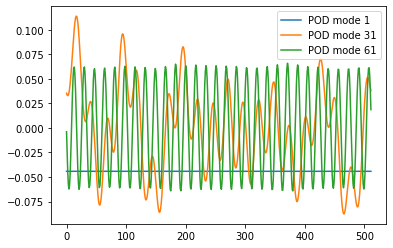

In [102]:
for j in range(0, Vr.shape[1], 30):
    plt.plot(x_all, Vr[:, j], label=f'POD mode {j+1}')

plt.legend(loc="upper right")
plt.show()

In [112]:
Q = Q.to_numpy()

In [113]:
Qdot2 = opinf.pre.ddt_uniform(Q, dt, order=6)

# Check that the estimate is close to the true time derivatives.
la.norm(Qdot - Qdot2, ord=np.inf) / la.norm(Qdot, ord=np.inf)

0.0038507147658283446

In [114]:
Q_ = Vr.T @ Q                                   # Project the state snapshots.
Qdot_ = opinf.pre.ddt_uniform(Q_, dt, order=6)  # Estimate the projected time derivatives.

np.allclose(Vr.T @ Qdot2, Qdot_)                # Same as project the full-order time derivatives.

True

In [115]:
rom = opinf.ContinuousOpInfROM('A')
rom

Reduced-order model structure: dq / dt = Aq(t)

In [116]:
rom.fit(basis=Vr, states=Q, ddts=Qdot)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 512
Reduced-order dimension r = 90

In [121]:
rom.fit(Vr, Q, Qdot, regularizer=1e-2)

array([[ 3.13385912e-08, -4.05435449e-08, -8.13100217e-06, ...,
        -1.29450220e-03,  2.59522550e-04, -1.59613824e-03],
       [-9.66623067e-06, -8.11382035e-06,  1.54233457e-03, ...,
        -6.82950899e-02,  5.40681692e-01, -4.53458206e-01],
       [ 4.15845209e-06, -1.45924908e-03, -1.57796806e-05, ...,
        -7.74076369e-02, -3.00205616e-03,  8.30104458e-01],
       ...,
       [-3.57203299e-08,  1.26448471e-06,  1.36418981e-06, ...,
         4.74172336e-05,  2.35218051e-03, -1.64592488e-02],
       [-2.80629689e-08, -8.70579030e-06,  1.86265305e-07, ...,
        -2.31197325e-03, -6.98089159e-06, -6.80866532e-03],
       [ 1.71504071e-08,  4.76420653e-06, -9.19568701e-06, ...,
         1.09812366e-02,  4.57151393e-03,  2.12664828e-05]])

In [122]:
Q_ROM = rom.predict(q0, t, method='BDF', max_step=dt)
Q_ROM.shape

(512, 200000)

In [149]:
fig = go.Figure(data =
    go.Contour(
        z=Q[:, :1000]
    ))
fig.update_layout(title='Original Q first 1000 steps')
fig.write_image('images/problem_3_q_first_1000_2.png')

![](images/problem_3_q_first_1000_2.png)

In [150]:
fig = go.Figure(data =
    go.Contour(
        z=Q_ROM[:, :1000]
    ))
fig.update_layout(title='Q ROM first 1000 steps')
fig.write_image('images/problem_3_qrom_first_1000_2.png')

![](images/problem_3_qrom_first_1000_2.png)

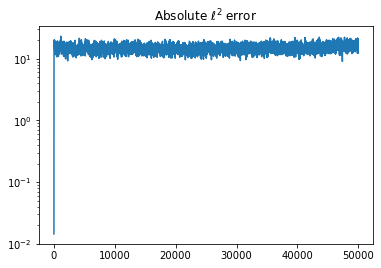

In [151]:
abs_l2err, rel_l2err = opinf.post.lp_error(Q, Q_ROM)
plt.semilogy(t, abs_l2err)
plt.title(r"Absolute $\ell^{2}$ error")
plt.show()

In [152]:
abs_froerr, rel_froerr = opinf.post.frobenius_error(Q, Q_ROM)
print(f"Relative Frobenius-norm error: {rel_froerr:%}")

Relative Frobenius-norm error: 96.046770%
